In [3]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import time
from torchvision.models import inception_v3
from torchvision.transforms import functional as TF
from torchvision import datasets, transforms
from scipy.stats import entropy


from torch.utils.data import Dataset, DataLoader
from torchvision import datasets, transforms


import os
from datetime import datetime
from torch.utils.tensorboard import SummaryWriter


#import wandb

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")
logged_in = False

Using device: cpu


In [3]:
FOLDER_PATH = '/content/drive/MyDrive/Deep Learning/ex3_305673212_312349509/FashionMNIST'
if (os.path.exists(FOLDER_PATH)):
  _PATH = FOLDER_PATH
else:
  _PATH = "data" #for git runs

In [4]:
#hyper parameters
#TODO: the WGAN paper states lr= 5e-5, should we use it?
DIM = 64 # Model dimensionality
BATCH_SIZE = 50 # Batch size
CRITIC_ITERS = 5 # For WGAN and WGAN-GP, number of critic iters per gen iter
LAMBDA = 10 # Gradient penalty lambda hyperparameter
GEN_ITERS = 200000 # How many generator iterations to train for
LATENT_DIM = 128
in_channels = 1
input_img_w = 28 #FashionMNIST Width
input_img_h = 28 #FashionMNIST Hight
OUTPUT_DIM = input_img_w*input_img_h # Number of pixels in MNIST (28*28)
CIFAR_SIZE = (32,32)


# W&B





In [5]:
#TODO: remove before submission
import wandb

if not logged_in:
    try:
        from mycreds import WANDB_API_KEY
        logged_in = wandb.login(key=WANDB_API_KEY)

    except ImportError:
        raise ImportError ("hi! its Nadav 😅\nprovide your WANDB_API_KEY in mycreds.py 🙏:\n"
              "1. Create a student/free account at https://wandb.ai/site 🔥\n"
              "2. copy your API key from https://wandb.ai/authorize\n"
              "3. create a file named mycreds.py in the same directory as this notebook\n"
              "4. add the following line to mycreds.py: WANDB_API_KEY = 'your API key'")

wandb: Currently logged in as: nadavo11 (nadavoteam). Use `wandb login --relogin` to force relogin
wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: Appending key for api.wandb.ai to your netrc file: C:\Users\nadav\_netrc


# Data Preprocessing
## Data loaders
let's prepare our data by loading it, normalizing it, and creating the data loaders.

In [81]:
""
# Define the transform to convert the images to tensors and normalize them and resize them to 32X32 to match CIFAR input

transform = transforms.Compose([
    transforms.ToTensor(),
])
# Download and load the training data
train_dataset = datasets.FashionMNIST(root=_PATH, train=True, download=True, transform=transform)
test_dataset = datasets.FashionMNIST(root=_PATH, train=False, download=True, transform=transform)

# Create DataLoader for training and testing
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

train_iter = iter(train_loader)

## Visualize the data

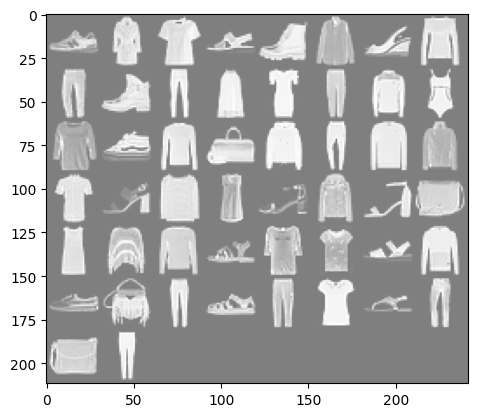

In [82]:
import torchvision


# Display some of the images
def imshow(img):
    img = img / 2 + 0.5  # unnormalize

    npimg = img.cpu().detach().numpy()

    plt.imshow(np.transpose(npimg, (1, 2, 0)), cmap='gray')
    plt.show()


def show_grid(images):
    imshow(torchvision.utils.make_grid(images))

# get some random training images
dataiter = iter(train_loader)
images, labels = next(dataiter)

show_grid(images)

# Network Architecture
We will implemnet gernerator and descriminator/critic as defined in "Improved Training of Wasserstein GANs" papaer for CIFAR10We decided to resize the FashionMNIST images from 28X28X1 to 32X32X1 to be able to use same conv layers used in the paper



# Generator

### conv dimensions
convolution dimensions are calculated as follows: $ x = \frac{W - k + 2P}{S} + 1 $ deconv dimensions are calculated as follows: $ x = S(W-1) + k - 2P + F $ where: - W is the input image size - k is the kernel size - P is the padding - S is the stride - F is the output padding


In [83]:


class Generator(nn.Module):

    def __init__(self,
                 dim=DIM,
                 latent_dim = LATENT_DIM):

        super(Generator, self).__init__()

        self.dim = dim
        self.latent_dim = latent_dim

        # 1. Fully connected:
        # 128 -> 4*4*4*dim
        self.linear = nn.Linear(latent_dim,
                                4*4*4*dim)

        self.bn1 = nn.BatchNorm1d(4*4*4*dim)

        # 2. deConv
        # (4x4) 4dim -> (8x8) 2dim
        self.deconv2 = nn.ConvTranspose2d(4*dim,
                                          2*dim,
                                          kernel_size=5,
                                          stride=2,
                                          padding=2,
                                          output_padding=1,
                                          bias=False)
        self.bn2 = nn.BatchNorm2d(2*dim)

        # 3. deConv
        # (8x8) 2dim -> (16x16) dim
        self.deconv3 = nn.ConvTranspose2d(2*dim,
                                          dim,
                                          kernel_size=5,
                                          stride=2,
                                          padding=2,
                                          output_padding=1,
                                          bias=False)
        self.bn3 = nn.BatchNorm2d(dim)

        # 4. deConv
        #(16x16) dim -> (32X32) 1
        self.deconv4 = nn.ConvTranspose2d(dim,
                                          in_channels,
                                          kernel_size=5,
                                          stride=2,
                                          padding=2,
                                          output_padding=1,
                                          bias=False)
        self.apply(self._weights_init)

    # avoid vanishing gradients due to bad initialization
    def _weights_init(self, m):
        if isinstance(m, nn.Conv2d) or isinstance(m, nn.Linear):
            nn.init.kaiming_normal_(m.weight, a=0.2, nonlinearity='leaky_relu')
            if m.bias is not None:
                nn.init.constant_(m.bias, 0)

    # TODO : complete forward function
    #  check if we need to add noise to the forward function
    def forward(self, n_samples, noise=None):
        if noise is None:
            noise = torch.randn(n_samples, self.latent_dim).to(device)

        # 1. Fully connected
        x = self.linear(noise)
        x = self.bn1(x)
        x = F.relu(x)
        x = x.view(-1, 4*self.dim, 4, 4)

        # 2.Deconv
        x = self.deconv2(x)
        x = self.bn2(x)
        x = F.relu(x)

        # 3. Deconv
        x = self.deconv3(x)
        x = self.bn3(x)
        x = F.relu(x)

        # 4. Deconv
        x = self.deconv4(x)
        x = F.tanh(x)

        return x


tensor([0.0000, 0.7616, 1.0000])


 # Discriminator

convolution dimensions are calculated as follows: $ x = \frac{W - k + 2P}{S} + 1 $ deconv dimensions are calculated as follows: $ x = S(W-1) + k - 2P + F $ where: - W is the input image size - k is the kernel size - P is the padding - S is the stride - F is the output padding

In [84]:
class Discriminator(nn.Module):
    def __init__(self,
                dim = DIM,
                in_channels = 1):

        super(Discriminator, self).__init__()
        self.in_features = in_channels
        self.dim=dim
        self.conv1 = nn.Conv2d(kernel_size=5,
                             in_channels=in_channels,
                             out_channels=self.dim,
                             stride=2,) # dimX14X4

        self.conv2 = nn.Conv2d(kernel_size=5,
                                in_channels=self.dim,
                                out_channels=2*self.dim,
                                stride=2,) # 2dimX5X5
        self.batch_norm2 = nn.BatchNorm2d(2*self.dim)

        self.conv3 = nn.Conv2d(kernel_size=1,
                                in_channels=2*self.dim,
                                out_channels=4*self.dim,
                                stride=1,) # 4dimX5X5
        self.batch_norm3 = nn.BatchNorm2d(4*self.dim)

        self.fc = nn.Linear(4*5*5*self.dim, 1)
        self.apply(self._weights_init)

    def _weights_init(self, m):
        if isinstance(m, nn.Conv2d) or isinstance(m, nn.Linear):
            nn.init.kaiming_normal_(m.weight, a=0.2, nonlinearity='leaky_relu')
            if m.bias is not None:
                nn.init.constant_(m.bias, 0)


    def forward(self, x):
        x = F.leaky_relu(self.conv1(x), negative_slope=0.2)
        x = self.conv2(x)
        x = self.batch_norm2(x)
        x = F.leaky_relu(x, negative_slope=0.2)
        x = self.conv3(x)
        x = self.batch_norm3(x)
        x = F.leaky_relu(x, negative_slope=0.2)
        x = x.view(-1, 4*5*5*self.dim)  # Flatten
        x = self.fc(x)
        x = F.tanh(x)
        return x


In [85]:
class GAN(nn.Module):
    def __init__(self,
                 dim=DIM,
                 mode='wgan',
                 latent_dim=LATENT_DIM,
                 ):
        super(GAN, self).__init__()
        self.generator = Generator(dim = dim,
                                   mode = mode,
                                   latent_dim= latent_dim)
        self.discriminator = Discriminator(dim = dim,
                                           mode = mode,in_channels=in_channels)


# Evaluation
## evaluation metric - Inception score
we define our evaluation metric as the inception score:

In [86]:
## Inception score (Evaluation)
def inception_score(images, batch_size=32, splits=10):
    # Load pre-trained InceptionV3 model
    inception_model = inception_v3(pretrained=True, transform_input=False).eval()
    
    def get_pred(x):
        with torch.no_grad():
            # Upsample images as InceptionV3 requires min 299x299
            x = F.interpolate(x, size=(299, 299), mode='bilinear', align_corners=False)
            # InceptionV3 needs input shape of N x 3 x 299 x 299
            x = x.repeat(1, 3, 1, 1)
            x = inception_model(x)
        return F.softmax(x, dim=1).cpu().numpy()
    
    # Resize images to 299x299 as required by InceptionV3
    images = [TF.resize(img, (299, 299)) for img in images]
    images = torch.stack(images)
    
    # Calculate predictions
    preds = []
    for i in range(0, len(images), batch_size):
        batch = images[i:i + batch_size]
        preds.append(get_pred(batch))
    preds = np.concatenate(preds, axis=0)
    
    # Calculate Inception Score
    split_scores = []
    for k in range(splits):
        part = preds[k * (len(preds) // splits): (k + 1) * (len(preds) // splits), :]
        py = np.mean(part, axis=0)
        scores = []
        for i in range(part.shape[0]):
            pyx = part[i, :]
            scores.append(entropy(pyx, py))
        split_scores.append(np.exp(np.mean(scores)))
    
    return np.mean(split_scores), np.std(split_scores)

def disc_cost (mode,disc_fake,disc_real):
    return (torch.mean(disc_fake) - torch.mean(disc_real) if mode == 'wgan' else
                            (F.binary_cross_entropy_with_logits(disc_fake, torch.zeros_like(disc_fake)) +
                                F.binary_cross_entropy_with_logits(disc_real, torch.ones_like(disc_real))) / 2.)

def gen_cost(disc_fake,mode):
    return (-torch.mean(disc_fake) if mode == 'wgan' else F.binary_cross_entropy_with_logits(disc_fake, torch.ones_like(disc_fake)))

## Test the generator
can be removed before submission

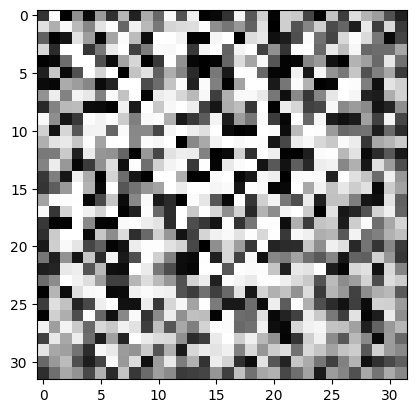

In [87]:
generator = Generator().to(device)
img = generator.forward(10)
imshow(img[0])

## Test the discriminator

In [88]:
discriminator = Discriminator().to(device)
output = discriminator.forward(img)
print(output)


tensor([[ 0.8446],
        [ 0.4808],
        [ 0.8644],
        [ 0.0355],
        [ 0.4245],
        [-0.9597],
        [-0.9601],
        [-0.9755],
        [-0.9627],
        [ 0.5438]], grad_fn=<TanhBackward0>)


#Lost Function/ Inception

In [89]:
def clip_weights(net, clip_value):
    for p in net.parameters():
        p.data.clamp_(-clip_value, clip_value)

# Training loop

In [92]:
  #TODO: Consider change it if training is too heavey
def inf_train_gen(train_loader = train_loader):
    while True:
        for images, _ in train_loader:
            yield images


def train(generator = generator,
          discriminator = discriminator,
          batch_size=BATCH_SIZE,
          train_loader=train_loader,
          val_loader=test_loader,

          lr = 5e-5,
          gen_iters=GEN_ITERS,
          critic_iters=CRITIC_ITERS,
          clipping_value=0.01,
          mode='wgan',
          gradient_clipping = False,
          weight_clipping = False

          ):

    gen_optimizer = optim.RMSprop(generator.parameters(), lr=lr)
    disc_optimizer = optim.RMSprop(discriminator.parameters(), lr=lr)


    # wandb
    wandb.init(
        # set the wandb project where this run will be logged
        project="GANs",
        # track hyperparameters and run metadata
        config={
            f"learning_rate": 5e-5,
            f"architecture": "VAE",
            f"dataset": "Fashion MNIST",
        })
    # Watch the model to log gradients and parameters
    wandb.watch(generator, log="all", log_freq=100)
    wandb.watch(discriminator, log="all", log_freq=100)

    for iteration in range(gen_iters):
        start_time = time.time()

        # Train generator freeze discriminator for speedup
        generator.train()
        discriminator.eval()

        # forward pass
        gen_optimizer.zero_grad()
        fake_data = generator(batch_size)
        disc_fake = discriminator(fake_data)

        #loss, why is it called val?
        gen_cost_val = gen_cost(mode=mode,disc_fake=disc_fake)
        gen_cost_val.backward()
        gen_optimizer.step()

        # Train critic/dicriminator
        disc_iters = 1 if mode == 'dcgan' else critic_iters
        for _ in range(disc_iters):


            _data = next(inf_train_gen()).to(device)
            discriminator.train()
            disc_optimizer.zero_grad()


            disc_real = discriminator(_data)

            # forward pass
            fake_data = generator(batch_size)
            disc_fake = discriminator(fake_data)

            #loss
            disc_cost_val =disc_cost(mode=mode,disc_real=disc_real,disc_fake=disc_fake)
            #backprop
            disc_cost_val.backward()

            # TODO: hey 👋 I added grad and weight clipping to try prevent the exploding grads & weights
            #  in the discriminator. see if it stabilizes the training

            if gradient_clipping:
                # grad clipping only on the discriminator
                torch.nn.utils.clip_grad_norm_(discriminator.parameters(), max_norm=0.1)
                disc_optimizer.step()

            # Apply weight clipping for WGAN
            if weight_clipping:
                clip_weights(discriminator, clipping_value)

        print(f"Iteration {iteration}, Generator Cost: {gen_cost_val}, Discriminator Cost: {disc_cost_val} Time: {time.time() - start_time}")
        wandb.log({"Generator Cost": gen_cost_val, "Discriminator Cost": disc_cost_val}, step=iteration)

        # Logging

        # Calculate inception score every 1K iters
        if iteration % 1000 == 999:
            with torch.no_grad():
                # z = torch.randn(1000, 100, 1, 1).to(device) this will break the code because it doesn't match the generator latent dimension
                generated_imgs = generator(100)
                generated_imgs = generated_imgs.cpu()
                inception_mean, inception_std = inception_score(generated_imgs)
                print(f"Genrator Iteration {iteration}: Inception Score: {inception_mean} ± {inception_std}")
                wandb.log({"Inception Score": inception_mean}, step=iteration)


                imshow(generated_imgs[0])
                plt.show()

        # Calculate val loss of the discriminator and generate samples every 100 iters
        if iteration % 100 == 99:

            val_disc_costs = []
            for images, _ in val_loader:
                # images = torch.tensor(images).float()  # Convert images to a PyTorch tensor
                fake_data = generator(batch_size)
                disc_fake = discriminator(fake_data)
                _dev_disc_cost = disc_cost(mode=mode,disc_real=images,disc_fake=disc_fake)  # Compute the discriminator cost
                val_disc_costs.append(_dev_disc_cost.item())  # Append the cost to the list
                wandb.log({"Validation Discriminator Cost": _dev_disc_cost}, step=iteration)

            imshow(fake_data[0])
            plt.show()



        # mean_dev_disc_cost = np.mean(val_disc_costs) #TODO plot


# Training a WGAN

In [1]:
generator = Generator().to(device)
discriminator = Discriminator().to(device)
train(mode = 'wgan'
      , train_loader=train_loader
      , gen_iters = GEN_ITERS
      , critic_iters=CRITIC_ITERS
      ,batch_size = BATCH_SIZE
      ,discriminator = discriminator
      ,generator = generator
      ,val_loader=test_loader)

In [115]:
class Decoder(nn.Module):

    def __init__(self,
                 hidden_dim = DIM,
                 latent_dim=LATENT_DIM):
        super().__init__()
        self.latent_dim = latent_dim

        self.fc1 = nn.Sequential(
            nn.Linear(latent_dim, hidden_dim),
            nn.ReLU()
        )
        self.fc2 = nn.Sequential(
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU()
        )
        self.fc3 = nn.Sequential(
            nn.Linear(hidden_dim, 64*7*7),
            nn.ReLU()
        )
        self.deconv1 = nn.Sequential(
            nn.ConvTranspose2d(in_channels=64,
                               out_channels=32,
                               kernel_size=3,
                               stride=2,
                               padding=1,
                               output_padding=1),  # 7x7 -> 14x14
            nn.ReLU()
        )
        self.deconv2 = nn.Sequential(
            nn.ConvTranspose2d(in_channels=32,
                               out_channels=1,
                               kernel_size=3,
                               stride=2,
                               padding=1,
                               output_padding=1),  # 14x14 -> 28x28
            nn.Sigmoid()
        )
        # Apply Xavier uniform initialization to the weights of fc1 and fc2
        nn.init.xavier_uniform_(self.fc1[0].weight)
        nn.init.xavier_uniform_(self.fc2[0].weight)
        nn.init.xavier_uniform_(self.fc3[0].weight)

    def forward(self, n_samples, noise=None):
        if noise is None:
            noise = torch.randn(n_samples, self.latent_dim).to(device)
        x = self.fc1(noise)
        x = self.fc2(x)
        x = self.fc3(x)
        x = x.view(x.size(0), 64, 7, 7)
        x = self.deconv1(x)
        x = self.deconv2(x)


        return x

In [116]:
class Encoder(nn.Module):

    def __init__(self,
                 hidden_dim =DIM,
                 latent_dim = LATENT_DIM
                 ):
        super().__init__()

        self.conv1 = nn.Sequential(
            nn.Conv2d(in_channels=1,
                      out_channels=32,
                      kernel_size=3,
                      stride=2,
                      padding=1),  # 28x28 -> 14x14
            nn.ReLU()
        )
        self.conv2 = nn.Sequential(
            nn.Conv2d(in_channels=32,
                      out_channels=64,
                      kernel_size=3,
                      stride=2,
                      padding=1),  # 14x14 -> 7x7
            nn.ReLU()
        )
        self.fc1 = nn.Linear(64*7*7, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, hidden_dim)
        self.mu_fc = nn.Linear(hidden_dim, 1)

        # Apply Xavier uniform initialization to the weights of fc1 and fc2
        nn.init.xavier_uniform_(self.fc1.weight)
        nn.init.xavier_uniform_(self.fc2.weight)
        nn.init.xavier_uniform_(self.mu_fc.weight)

    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        x = x.view(x.size(0), -1)
        x = self.fc1(x)
        x = F.relu(x)
        x =self.fc2(x)
        x = self.mu_fc(x)
        x = F.tanh(x)

        return x

test the generator

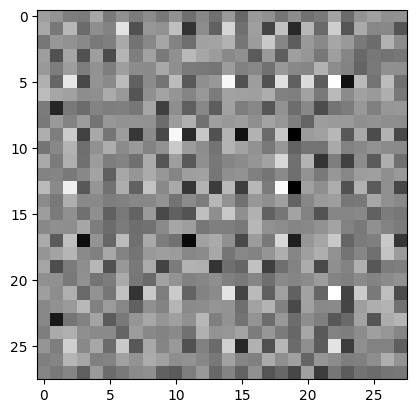

In [117]:
decoder = Decoder().to(device)
img = decoder(10)
imshow(img[0])

## test the discriminator

In [118]:
discriminator = Encoder().to(device)
output = discriminator.forward(img)
print(output)

tensor([[0.0921],
        [0.0919],
        [0.0906],
        [0.0935],
        [0.0899],
        [0.0913],
        [0.0908],
        [0.0891],
        [0.0902],
        [0.0902]], grad_fn=<TanhBackward0>)


Discriminator Cost,▁▂▃▄▅▅▆▆▇▇▇▇████████████████████████████
Generator Cost,█▇▆▅▄▄▃▃▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
Inception Score,▁
Validation Discriminator Cost,▁▃▅▆▇▇█████████████
Discriminator Cost,1.65324
Generator Cost,-1.79195
Inception Score,1.00392
Validation Discriminator Cost,1.49906


Iteration 0, Generator Cost: 0.23440681397914886, Discriminator Cost: 0.019064828753471375 Time: 0.31321048736572266
Iteration 1, Generator Cost: 0.2226313203573227, Discriminator Cost: 0.024214446544647217 Time: 0.23818469047546387
Iteration 2, Generator Cost: 0.2143896520137787, Discriminator Cost: 0.037279099225997925 Time: 0.22239255905151367
Iteration 3, Generator Cost: 0.2077985554933548, Discriminator Cost: 0.030295610427856445 Time: 0.22285723686218262
Iteration 4, Generator Cost: 0.20005404949188232, Discriminator Cost: 0.03690728545188904 Time: 0.21439909934997559
Iteration 5, Generator Cost: 0.19447249174118042, Discriminator Cost: 0.05006611347198486 Time: 0.20196866989135742
Iteration 6, Generator Cost: 0.18491289019584656, Discriminator Cost: 0.06052775681018829 Time: 0.3073606491088867
Iteration 7, Generator Cost: 0.1810690462589264, Discriminator Cost: 0.058629781007766724 Time: 0.28948450088500977
Iteration 8, Generator Cost: 0.17309841513633728, Discriminator Cost: 0.

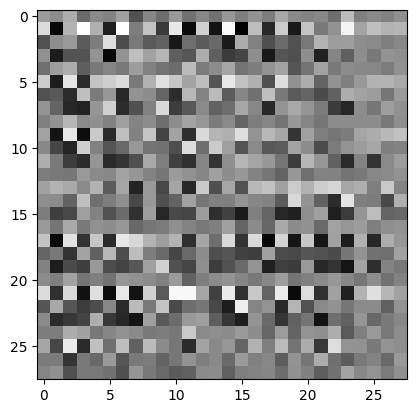

Iteration 100, Generator Cost: -0.4376496970653534, Discriminator Cost: 0.6803602576255798 Time: 0.3285343647003174
Iteration 101, Generator Cost: -0.44376140832901, Discriminator Cost: 0.6821693181991577 Time: 0.22282004356384277
Iteration 102, Generator Cost: -0.4527631998062134, Discriminator Cost: 0.6804533004760742 Time: 0.24330544471740723
Iteration 103, Generator Cost: -0.44232383370399475, Discriminator Cost: 0.6987120509147644 Time: 0.2805814743041992
Iteration 104, Generator Cost: -0.4515702426433563, Discriminator Cost: 0.6977905035018921 Time: 0.22460460662841797
Iteration 105, Generator Cost: -0.44567352533340454, Discriminator Cost: 0.6928826570510864 Time: 0.23018169403076172
Iteration 106, Generator Cost: -0.46416282653808594, Discriminator Cost: 0.7057018876075745 Time: 0.22589707374572754
Iteration 107, Generator Cost: -0.47375014424324036, Discriminator Cost: 0.7234801650047302 Time: 0.2119002342224121
Iteration 108, Generator Cost: -0.46298012137413025, Discriminato

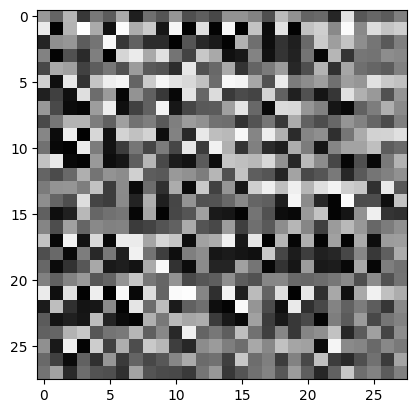

Iteration 200, Generator Cost: -0.6949929594993591, Discriminator Cost: 0.9319608807563782 Time: 0.3155984878540039
Iteration 201, Generator Cost: -0.6822224259376526, Discriminator Cost: 0.9425718784332275 Time: 0.3799431324005127
Iteration 202, Generator Cost: -0.6919534206390381, Discriminator Cost: 0.928277850151062 Time: 0.24426007270812988
Iteration 203, Generator Cost: -0.6909922957420349, Discriminator Cost: 0.9258164763450623 Time: 0.24928808212280273
Iteration 204, Generator Cost: -0.6936813592910767, Discriminator Cost: 0.9365801215171814 Time: 0.2803201675415039
Iteration 205, Generator Cost: -0.6893657445907593, Discriminator Cost: 0.934299647808075 Time: 0.3030543327331543
Iteration 206, Generator Cost: -0.6879413723945618, Discriminator Cost: 0.9374154210090637 Time: 0.29619479179382324
Iteration 207, Generator Cost: -0.7006053328514099, Discriminator Cost: 0.9350548982620239 Time: 0.3096129894256592
Iteration 208, Generator Cost: -0.714192271232605, Discriminator Cost: 

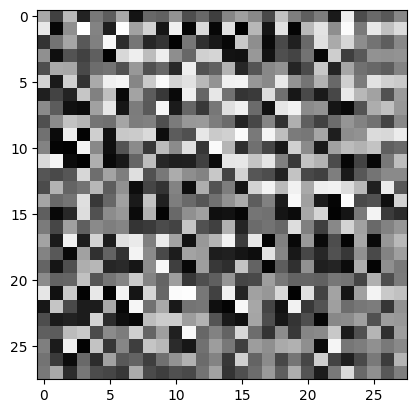

Iteration 300, Generator Cost: -0.8112921714782715, Discriminator Cost: 1.0684818029403687 Time: 0.4291093349456787
Iteration 301, Generator Cost: -0.8128736019134521, Discriminator Cost: 1.0563157796859741 Time: 0.42500925064086914
Iteration 302, Generator Cost: -0.8136460185050964, Discriminator Cost: 1.0450936555862427 Time: 0.4210019111633301
Iteration 303, Generator Cost: -0.8060416579246521, Discriminator Cost: 1.0603080987930298 Time: 0.22704768180847168
Iteration 304, Generator Cost: -0.8071820735931396, Discriminator Cost: 1.0417757034301758 Time: 0.19524335861206055
Iteration 305, Generator Cost: -0.8057243227958679, Discriminator Cost: 1.052527904510498 Time: 0.25537109375
Iteration 306, Generator Cost: -0.8175406455993652, Discriminator Cost: 1.0513131618499756 Time: 0.3051731586456299
Iteration 307, Generator Cost: -0.8206327557563782, Discriminator Cost: 1.0515879392623901 Time: 0.1980292797088623
Iteration 308, Generator Cost: -0.815681517124176, Discriminator Cost: 1.03

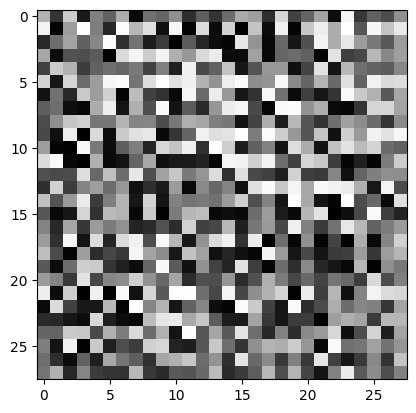

Iteration 400, Generator Cost: -0.8742012977600098, Discriminator Cost: 1.1259129047393799 Time: 0.2736954689025879
Iteration 401, Generator Cost: -0.8681739568710327, Discriminator Cost: 1.0923874378204346 Time: 0.2146167755126953
Iteration 402, Generator Cost: -0.8689206838607788, Discriminator Cost: 1.1066838502883911 Time: 0.292743444442749
Iteration 403, Generator Cost: -0.8709210753440857, Discriminator Cost: 1.099010944366455 Time: 0.18777823448181152
Iteration 404, Generator Cost: -0.8736433386802673, Discriminator Cost: 1.1177453994750977 Time: 0.19641518592834473
Iteration 405, Generator Cost: -0.8731212019920349, Discriminator Cost: 1.1023560762405396 Time: 0.21110272407531738
Iteration 406, Generator Cost: -0.869907557964325, Discriminator Cost: 1.107032060623169 Time: 0.200636625289917
Iteration 407, Generator Cost: -0.8701973557472229, Discriminator Cost: 1.1252310276031494 Time: 0.31845641136169434
Iteration 408, Generator Cost: -0.8721078634262085, Discriminator Cost: 1

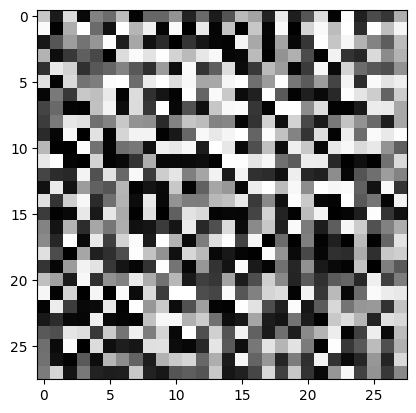

Iteration 500, Generator Cost: -0.9004634022712708, Discriminator Cost: 1.1311613321304321 Time: 0.2540628910064697
Iteration 501, Generator Cost: -0.904714047908783, Discriminator Cost: 1.1396756172180176 Time: 0.31967997550964355
Iteration 502, Generator Cost: -0.9046443700790405, Discriminator Cost: 1.1524159908294678 Time: 0.35166430473327637
Iteration 503, Generator Cost: -0.9066346883773804, Discriminator Cost: 1.1399765014648438 Time: 0.29049110412597656
Iteration 504, Generator Cost: -0.9038207530975342, Discriminator Cost: 1.1495540142059326 Time: 0.22608590126037598
Iteration 505, Generator Cost: -0.9069737195968628, Discriminator Cost: 1.1512556076049805 Time: 0.21878337860107422
Iteration 506, Generator Cost: -0.9055154323577881, Discriminator Cost: 1.1414861679077148 Time: 0.2532079219818115
Iteration 507, Generator Cost: -0.9029295444488525, Discriminator Cost: 1.1425626277923584 Time: 0.34201788902282715
Iteration 508, Generator Cost: -0.9054535031318665, Discriminator C

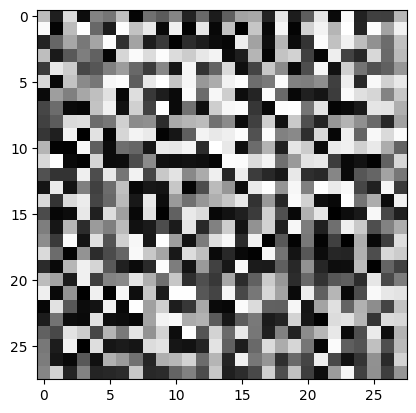

Iteration 600, Generator Cost: -0.9269727468490601, Discriminator Cost: 1.153577446937561 Time: 0.2651844024658203
Iteration 601, Generator Cost: -0.9269038438796997, Discriminator Cost: 1.161099910736084 Time: 0.20578670501708984
Iteration 602, Generator Cost: -0.9260014891624451, Discriminator Cost: 1.1464098691940308 Time: 0.18877792358398438
Iteration 603, Generator Cost: -0.923504650592804, Discriminator Cost: 1.1655621528625488 Time: 0.20303010940551758
Iteration 604, Generator Cost: -0.923572301864624, Discriminator Cost: 1.1772409677505493 Time: 0.2188272476196289
Iteration 605, Generator Cost: -0.9257510304450989, Discriminator Cost: 1.153232455253601 Time: 0.24881601333618164
Iteration 606, Generator Cost: -0.9264398813247681, Discriminator Cost: 1.1560205221176147 Time: 0.27386021614074707
Iteration 607, Generator Cost: -0.9262853860855103, Discriminator Cost: 1.156820297241211 Time: 0.32089948654174805
Iteration 608, Generator Cost: -0.9254214763641357, Discriminator Cost: 

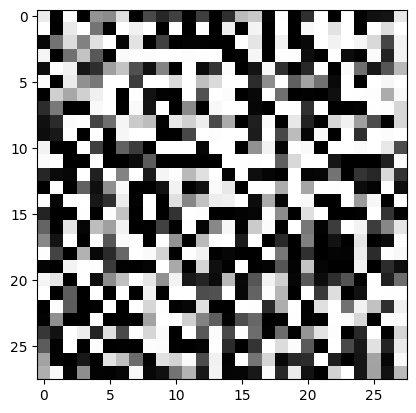

Iteration 700, Generator Cost: -0.937915027141571, Discriminator Cost: 1.1860013008117676 Time: 0.2939283847808838
Iteration 701, Generator Cost: -0.9361960887908936, Discriminator Cost: 1.1711559295654297 Time: 0.24448919296264648
Iteration 702, Generator Cost: -0.9384786486625671, Discriminator Cost: 1.1883257627487183 Time: 0.48703670501708984
Iteration 703, Generator Cost: -0.9383751749992371, Discriminator Cost: 1.1884104013442993 Time: 0.4549543857574463
Iteration 704, Generator Cost: -0.9382996559143066, Discriminator Cost: 1.1679223775863647 Time: 0.20274734497070312
Iteration 705, Generator Cost: -0.9373483061790466, Discriminator Cost: 1.1820801496505737 Time: 0.20527958869934082
Iteration 706, Generator Cost: -0.9376968145370483, Discriminator Cost: 1.1858620643615723 Time: 0.26935529708862305
Iteration 707, Generator Cost: -0.9390905499458313, Discriminator Cost: 1.1759552955627441 Time: 0.24532294273376465
Iteration 708, Generator Cost: -0.9381223320960999, Discriminator C

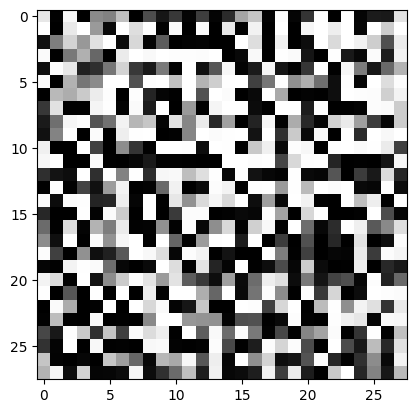

Iteration 800, Generator Cost: -0.9458247423171997, Discriminator Cost: 1.1911669969558716 Time: 0.46624231338500977
Iteration 801, Generator Cost: -0.9455011487007141, Discriminator Cost: 1.179058313369751 Time: 0.4373047351837158
Iteration 802, Generator Cost: -0.9455075860023499, Discriminator Cost: 1.1696761846542358 Time: 0.4911048412322998
Iteration 803, Generator Cost: -0.9447981119155884, Discriminator Cost: 1.192704439163208 Time: 0.3708662986755371
Iteration 804, Generator Cost: -0.9455677270889282, Discriminator Cost: 1.1846505403518677 Time: 0.33965587615966797
Iteration 805, Generator Cost: -0.9464318156242371, Discriminator Cost: 1.188201904296875 Time: 0.4200749397277832
Iteration 806, Generator Cost: -0.9463714361190796, Discriminator Cost: 1.1891916990280151 Time: 0.37476253509521484
Iteration 807, Generator Cost: -0.945889949798584, Discriminator Cost: 1.1730393171310425 Time: 0.2787775993347168
Iteration 808, Generator Cost: -0.9466306567192078, Discriminator Cost: 1

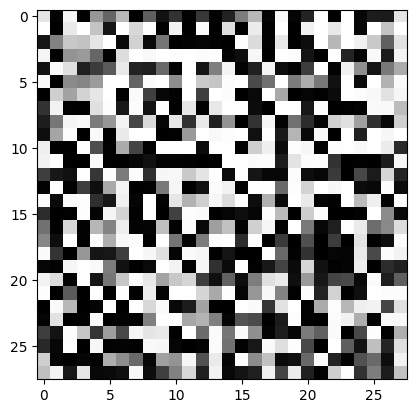

Iteration 900, Generator Cost: -0.9513554573059082, Discriminator Cost: 1.1869386434555054 Time: 0.351090669631958
Iteration 901, Generator Cost: -0.9512048363685608, Discriminator Cost: 1.186521291732788 Time: 0.25289273262023926
Iteration 902, Generator Cost: -0.951264500617981, Discriminator Cost: 1.1746619939804077 Time: 0.3387753963470459
Iteration 903, Generator Cost: -0.9517208933830261, Discriminator Cost: 1.2018312215805054 Time: 0.4381425380706787
Iteration 904, Generator Cost: -0.9522327184677124, Discriminator Cost: 1.2086490392684937 Time: 0.27881407737731934
Iteration 905, Generator Cost: -0.9518457055091858, Discriminator Cost: 1.1884682178497314 Time: 0.19126057624816895
Iteration 906, Generator Cost: -0.9513213634490967, Discriminator Cost: 1.1777410507202148 Time: 0.2606797218322754
Iteration 907, Generator Cost: -0.9515708684921265, Discriminator Cost: 1.1941287517547607 Time: 0.26305365562438965
Iteration 908, Generator Cost: -0.9517305493354797, Discriminator Cost:

C:\Users\nadav\anaconda3\envs\DCGAN-and-WGAN1\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
C:\Users\nadav\anaconda3\envs\DCGAN-and-WGAN1\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=Inception_V3_Weights.IMAGENET1K_V1`. You can also use `weights=Inception_V3_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Genrator Iteration 999: Inception Score: 1.0103644141842056 ± 0.005023672164839239


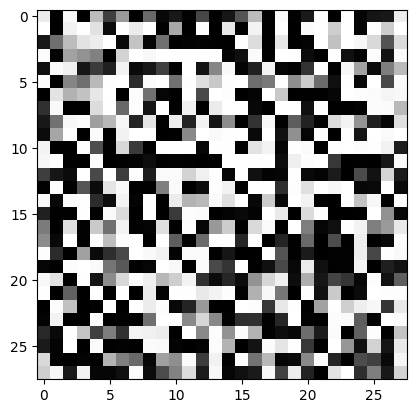

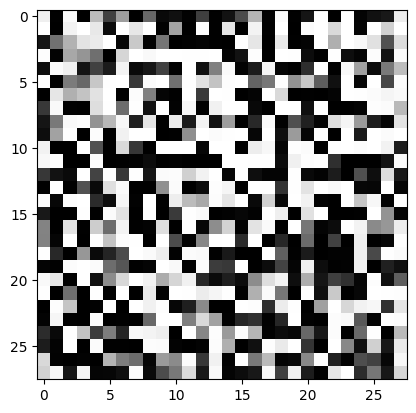

Iteration 1000, Generator Cost: -0.9559566378593445, Discriminator Cost: 1.1915746927261353 Time: 0.35663652420043945
Iteration 1001, Generator Cost: -0.954954206943512, Discriminator Cost: 1.202167272567749 Time: 0.40499114990234375
Iteration 1002, Generator Cost: -0.9555991291999817, Discriminator Cost: 1.1967222690582275 Time: 0.25046825408935547
Iteration 1003, Generator Cost: -0.9558959007263184, Discriminator Cost: 1.1847620010375977 Time: 0.41138291358947754
Iteration 1004, Generator Cost: -0.9558993577957153, Discriminator Cost: 1.184332251548767 Time: 0.25510430335998535
Iteration 1005, Generator Cost: -0.9562691450119019, Discriminator Cost: 1.1944416761398315 Time: 0.21007657051086426
Iteration 1006, Generator Cost: -0.9553144574165344, Discriminator Cost: 1.1919256448745728 Time: 0.4103243350982666
Iteration 1007, Generator Cost: -0.9553307294845581, Discriminator Cost: 1.1948972940444946 Time: 0.3570835590362549
Iteration 1008, Generator Cost: -0.9560258984565735, Discrimi

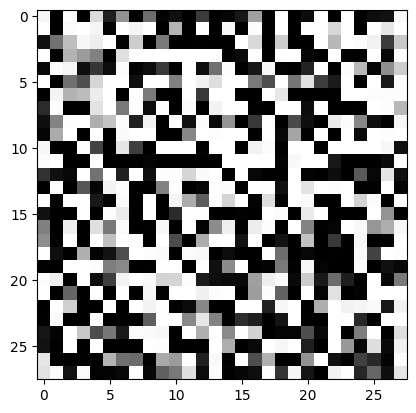

Iteration 1100, Generator Cost: -0.9575855135917664, Discriminator Cost: 1.2064697742462158 Time: 0.40818238258361816
Iteration 1101, Generator Cost: -0.9579871296882629, Discriminator Cost: 1.1991171836853027 Time: 0.28994107246398926
Iteration 1102, Generator Cost: -0.9577751159667969, Discriminator Cost: 1.2053452730178833 Time: 0.2679102420806885
Iteration 1103, Generator Cost: -0.9576364159584045, Discriminator Cost: 1.1974186897277832 Time: 0.3343789577484131
Iteration 1104, Generator Cost: -0.9578062295913696, Discriminator Cost: 1.178524374961853 Time: 0.40343236923217773
Iteration 1105, Generator Cost: -0.9579623937606812, Discriminator Cost: 1.1974565982818604 Time: 0.31923794746398926
Iteration 1106, Generator Cost: -0.9578650593757629, Discriminator Cost: 1.2017687559127808 Time: 0.43622899055480957
Iteration 1107, Generator Cost: -0.9579483270645142, Discriminator Cost: 1.1834465265274048 Time: 0.34946250915527344
Iteration 1108, Generator Cost: -0.9581832885742188, Discri

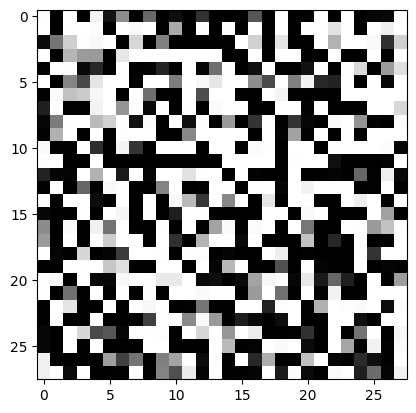

Iteration 1200, Generator Cost: -0.9589227437973022, Discriminator Cost: 1.188565969467163 Time: 0.32710862159729004
Iteration 1201, Generator Cost: -0.9590685367584229, Discriminator Cost: 1.1826636791229248 Time: 0.3522830009460449
Iteration 1202, Generator Cost: -0.959064245223999, Discriminator Cost: 1.1888498067855835 Time: 0.265455961227417
Iteration 1203, Generator Cost: -0.9590263366699219, Discriminator Cost: 1.1975712776184082 Time: 0.26209473609924316
Iteration 1204, Generator Cost: -0.9591342210769653, Discriminator Cost: 1.2067811489105225 Time: 0.34354066848754883
Iteration 1205, Generator Cost: -0.9591054320335388, Discriminator Cost: 1.1944669485092163 Time: 0.364774227142334
Iteration 1206, Generator Cost: -0.9592554569244385, Discriminator Cost: 1.2064393758773804 Time: 0.2945668697357178
Iteration 1207, Generator Cost: -0.9589903354644775, Discriminator Cost: 1.203648567199707 Time: 0.30629420280456543
Iteration 1208, Generator Cost: -0.9590700268745422, Discriminato

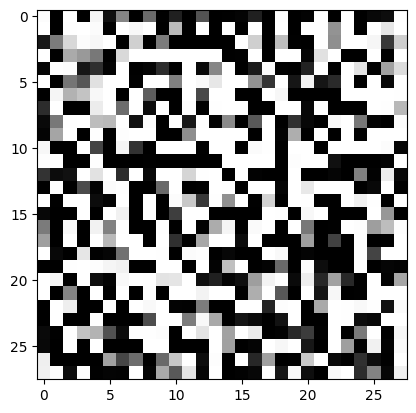

Iteration 1300, Generator Cost: -0.9607328772544861, Discriminator Cost: 1.204072117805481 Time: 0.30018162727355957
Iteration 1301, Generator Cost: -0.9606670141220093, Discriminator Cost: 1.200725793838501 Time: 0.22484135627746582
Iteration 1302, Generator Cost: -0.9605531096458435, Discriminator Cost: 1.2093194723129272 Time: 0.40817880630493164
Iteration 1303, Generator Cost: -0.9607222080230713, Discriminator Cost: 1.1984751224517822 Time: 0.39099574089050293
Iteration 1304, Generator Cost: -0.9605306386947632, Discriminator Cost: 1.197164535522461 Time: 0.4087181091308594
Iteration 1305, Generator Cost: -0.9607561230659485, Discriminator Cost: 1.2015830278396606 Time: 0.4056880474090576
Iteration 1306, Generator Cost: -0.9605984687805176, Discriminator Cost: 1.2015007734298706 Time: 0.33226966857910156
Iteration 1307, Generator Cost: -0.9606424570083618, Discriminator Cost: 1.1900912523269653 Time: 0.22784948348999023
Iteration 1308, Generator Cost: -0.960537314414978, Discrimin

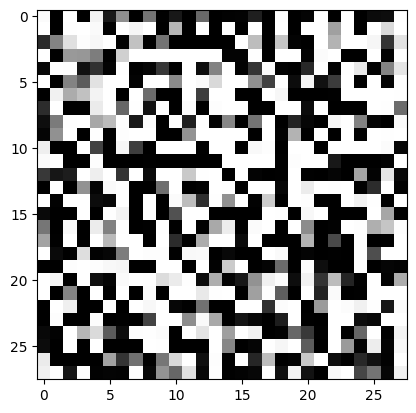

Iteration 1400, Generator Cost: -0.9615192413330078, Discriminator Cost: 1.1905713081359863 Time: 0.24311161041259766
Iteration 1401, Generator Cost: -0.9614942073822021, Discriminator Cost: 1.1939548254013062 Time: 0.20299696922302246
Iteration 1402, Generator Cost: -0.9613708257675171, Discriminator Cost: 1.1936969757080078 Time: 0.19652581214904785
Iteration 1403, Generator Cost: -0.9614326357841492, Discriminator Cost: 1.1957522630691528 Time: 0.2335526943206787
Iteration 1404, Generator Cost: -0.9614726305007935, Discriminator Cost: 1.1923848390579224 Time: 0.23233962059020996
Iteration 1405, Generator Cost: -0.9614371657371521, Discriminator Cost: 1.1863532066345215 Time: 0.23533344268798828
Iteration 1406, Generator Cost: -0.9615238308906555, Discriminator Cost: 1.1854043006896973 Time: 0.2145068645477295
Iteration 1407, Generator Cost: -0.9615651965141296, Discriminator Cost: 1.2111603021621704 Time: 0.2237098217010498
Iteration 1408, Generator Cost: -0.9614436626434326, Discri

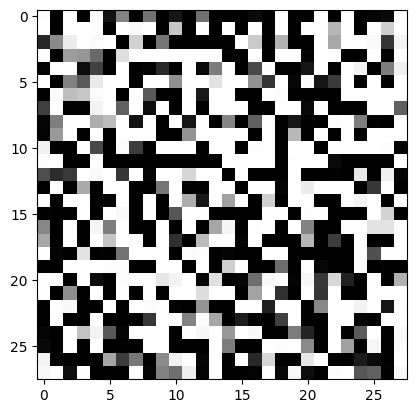

Iteration 1500, Generator Cost: -0.9618671536445618, Discriminator Cost: 1.2051806449890137 Time: 0.38580822944641113
Iteration 1501, Generator Cost: -0.9619473218917847, Discriminator Cost: 1.219412088394165 Time: 0.2657296657562256
Iteration 1502, Generator Cost: -0.96196448802948, Discriminator Cost: 1.2195947170257568 Time: 0.18800759315490723
Iteration 1503, Generator Cost: -0.9619382619857788, Discriminator Cost: 1.1951360702514648 Time: 0.21723151206970215
Iteration 1504, Generator Cost: -0.9619200229644775, Discriminator Cost: 1.1822381019592285 Time: 0.229522705078125
Iteration 1505, Generator Cost: -0.961899995803833, Discriminator Cost: 1.2019402980804443 Time: 0.22666001319885254
Iteration 1506, Generator Cost: -0.9619731307029724, Discriminator Cost: 1.2031522989273071 Time: 0.32703161239624023
Iteration 1507, Generator Cost: -0.9619076251983643, Discriminator Cost: 1.2105529308319092 Time: 0.3734445571899414
Iteration 1508, Generator Cost: -0.9619418978691101, Discriminat

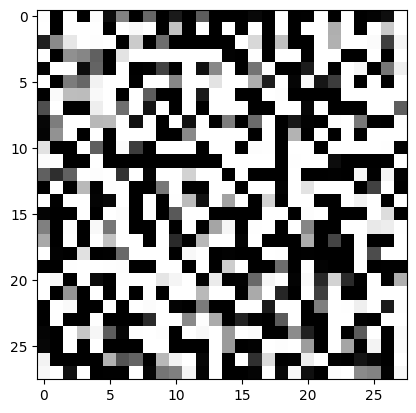

Iteration 1600, Generator Cost: -0.962199330329895, Discriminator Cost: 1.2008280754089355 Time: 0.27926087379455566
Iteration 1601, Generator Cost: -0.9621448516845703, Discriminator Cost: 1.1993637084960938 Time: 0.2566196918487549
Iteration 1602, Generator Cost: -0.9622949957847595, Discriminator Cost: 1.1916927099227905 Time: 0.18506741523742676
Iteration 1603, Generator Cost: -0.9622199535369873, Discriminator Cost: 1.202438235282898 Time: 0.23858904838562012
Iteration 1604, Generator Cost: -0.9622604250907898, Discriminator Cost: 1.1876296997070312 Time: 0.19018959999084473
Iteration 1605, Generator Cost: -0.9621812701225281, Discriminator Cost: 1.1813710927963257 Time: 0.20160937309265137
Iteration 1606, Generator Cost: -0.9622251391410828, Discriminator Cost: 1.1980938911437988 Time: 0.23223018646240234
Iteration 1607, Generator Cost: -0.962229311466217, Discriminator Cost: 1.1841486692428589 Time: 0.27185606956481934
Iteration 1608, Generator Cost: -0.9621759057044983, Discrim

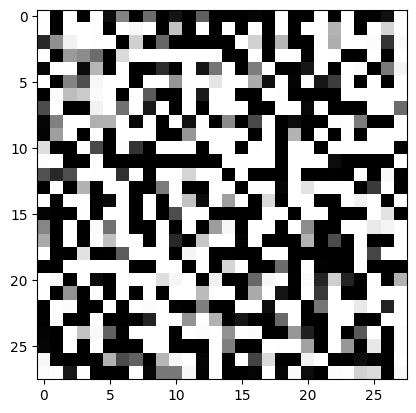

Iteration 1700, Generator Cost: -0.9625783562660217, Discriminator Cost: 1.2074865102767944 Time: 0.2882554531097412
Iteration 1701, Generator Cost: -0.9624795317649841, Discriminator Cost: 1.196558952331543 Time: 0.1968834400177002
Iteration 1702, Generator Cost: -0.9625927805900574, Discriminator Cost: 1.2139978408813477 Time: 0.2860102653503418
Iteration 1703, Generator Cost: -0.9625031352043152, Discriminator Cost: 1.195709466934204 Time: 0.24245333671569824
Iteration 1704, Generator Cost: -0.9625499844551086, Discriminator Cost: 1.1914499998092651 Time: 0.3301999568939209
Iteration 1705, Generator Cost: -0.9625445604324341, Discriminator Cost: 1.2029211521148682 Time: 0.32080507278442383
Iteration 1706, Generator Cost: -0.9625255465507507, Discriminator Cost: 1.1842451095581055 Time: 0.3480048179626465
Iteration 1707, Generator Cost: -0.9625415205955505, Discriminator Cost: 1.1935524940490723 Time: 0.3629744052886963
Iteration 1708, Generator Cost: -0.9625257849693298, Discriminat

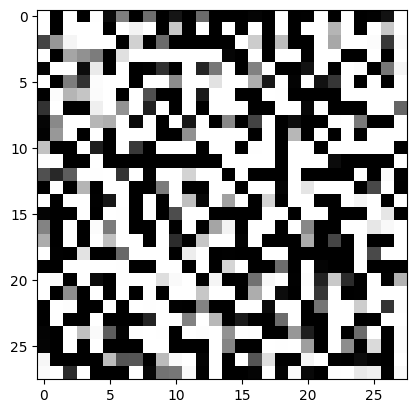

Iteration 1800, Generator Cost: -0.9627326130867004, Discriminator Cost: 1.2005409002304077 Time: 0.22557616233825684
Iteration 1801, Generator Cost: -0.9627565145492554, Discriminator Cost: 1.1980650424957275 Time: 0.2989819049835205
Iteration 1802, Generator Cost: -0.9627229571342468, Discriminator Cost: 1.1997789144515991 Time: 0.1906137466430664
Iteration 1803, Generator Cost: -0.9627139568328857, Discriminator Cost: 1.2004927396774292 Time: 0.2684907913208008
Iteration 1804, Generator Cost: -0.9627374410629272, Discriminator Cost: 1.1911020278930664 Time: 0.19343018531799316
Iteration 1805, Generator Cost: -0.9627466797828674, Discriminator Cost: 1.1869187355041504 Time: 0.2362806797027588
Iteration 1806, Generator Cost: -0.9627168774604797, Discriminator Cost: 1.183054804801941 Time: 0.28798604011535645
Iteration 1807, Generator Cost: -0.9626274704933167, Discriminator Cost: 1.2117254734039307 Time: 0.23798775672912598
Iteration 1808, Generator Cost: -0.962760865688324, Discrimin

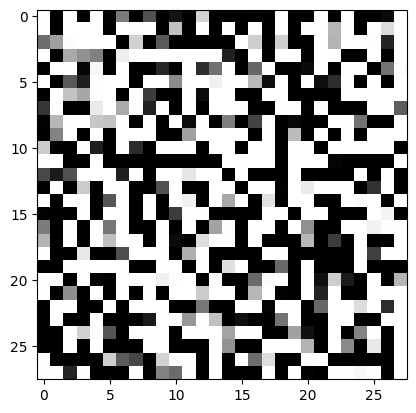

Iteration 1900, Generator Cost: -0.9629403948783875, Discriminator Cost: 1.2129355669021606 Time: 0.23386764526367188
Iteration 1901, Generator Cost: -0.9629916548728943, Discriminator Cost: 1.204420566558838 Time: 0.22512602806091309
Iteration 1902, Generator Cost: -0.9630053639411926, Discriminator Cost: 1.2002520561218262 Time: 0.22617053985595703
Iteration 1903, Generator Cost: -0.9630079865455627, Discriminator Cost: 1.1981003284454346 Time: 0.2385549545288086
Iteration 1904, Generator Cost: -0.9630075693130493, Discriminator Cost: 1.1941173076629639 Time: 0.25513267517089844
Iteration 1905, Generator Cost: -0.9629837870597839, Discriminator Cost: 1.1960675716400146 Time: 0.4426889419555664
Iteration 1906, Generator Cost: -0.9629826545715332, Discriminator Cost: 1.2069203853607178 Time: 0.24010825157165527
Iteration 1907, Generator Cost: -0.963019609451294, Discriminator Cost: 1.200190544128418 Time: 0.21518969535827637
Iteration 1908, Generator Cost: -0.9630324840545654, Discrimi

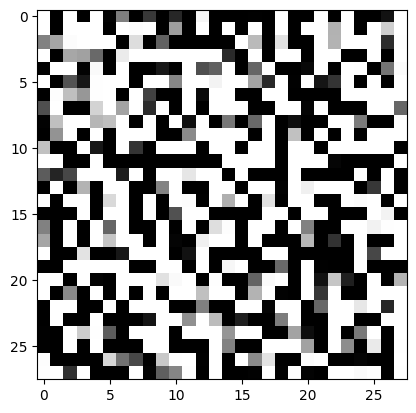

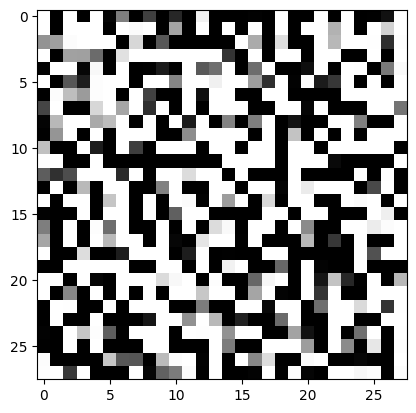

Iteration 2000, Generator Cost: -0.9632939696311951, Discriminator Cost: 1.2019550800323486 Time: 0.3298461437225342
Iteration 2001, Generator Cost: -0.9633162021636963, Discriminator Cost: 1.1932090520858765 Time: 0.16474509239196777
Iteration 2002, Generator Cost: -0.9632590413093567, Discriminator Cost: 1.1937408447265625 Time: 0.20565581321716309
Iteration 2003, Generator Cost: -0.9632121920585632, Discriminator Cost: 1.2136447429656982 Time: 0.2180008888244629
Iteration 2004, Generator Cost: -0.9632751941680908, Discriminator Cost: 1.210669994354248 Time: 0.23681402206420898
Iteration 2005, Generator Cost: -0.963285505771637, Discriminator Cost: 1.2052912712097168 Time: 0.22451257705688477
Iteration 2006, Generator Cost: -0.96331787109375, Discriminator Cost: 1.1943649053573608 Time: 0.350292444229126
Iteration 2007, Generator Cost: -0.9633142352104187, Discriminator Cost: 1.2126812934875488 Time: 0.37340879440307617
Iteration 2008, Generator Cost: -0.9633143544197083, Discriminat

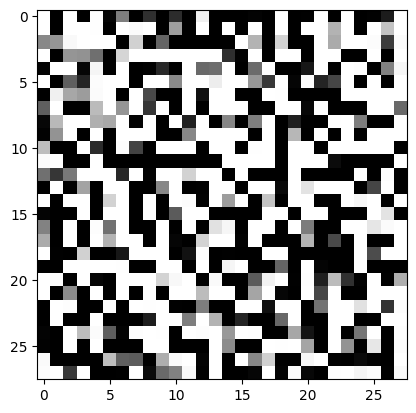

Iteration 2100, Generator Cost: -0.9633617997169495, Discriminator Cost: 1.1951690912246704 Time: 0.34376049041748047
Iteration 2101, Generator Cost: -0.9633973836898804, Discriminator Cost: 1.18437922000885 Time: 0.1876051425933838
Iteration 2102, Generator Cost: -0.9633837938308716, Discriminator Cost: 1.1902996301651 Time: 0.17817401885986328
Iteration 2103, Generator Cost: -0.9633590579032898, Discriminator Cost: 1.2054423093795776 Time: 0.17594599723815918
Iteration 2104, Generator Cost: -0.963355541229248, Discriminator Cost: 1.1982876062393188 Time: 0.3348658084869385
Iteration 2105, Generator Cost: -0.9633617997169495, Discriminator Cost: 1.2187347412109375 Time: 0.4129502773284912
Iteration 2106, Generator Cost: -0.9633423686027527, Discriminator Cost: 1.1872401237487793 Time: 0.3698418140411377
Iteration 2107, Generator Cost: -0.9632731676101685, Discriminator Cost: 1.1973154544830322 Time: 0.3371083736419678
Iteration 2108, Generator Cost: -0.9633920192718506, Discriminator 

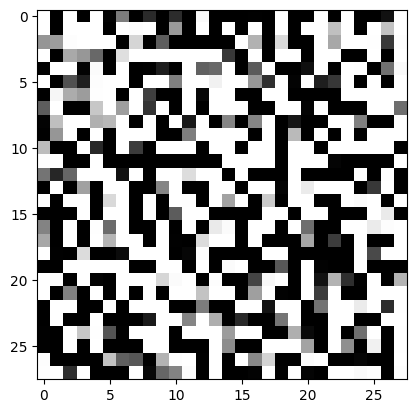

Iteration 2200, Generator Cost: -0.9633859395980835, Discriminator Cost: 1.2094147205352783 Time: 0.35349321365356445
Iteration 2201, Generator Cost: -0.9633538126945496, Discriminator Cost: 1.2093771696090698 Time: 0.20409631729125977
Iteration 2202, Generator Cost: -0.963416337966919, Discriminator Cost: 1.1966538429260254 Time: 0.19289731979370117
Iteration 2203, Generator Cost: -0.963472306728363, Discriminator Cost: 1.2039943933486938 Time: 0.2181711196899414
Iteration 2204, Generator Cost: -0.9634101986885071, Discriminator Cost: 1.2026697397232056 Time: 0.20197534561157227
Iteration 2205, Generator Cost: -0.9633730053901672, Discriminator Cost: 1.202185034751892 Time: 0.2644338607788086
Iteration 2206, Generator Cost: -0.9633857607841492, Discriminator Cost: 1.2144509553909302 Time: 0.3684999942779541
Iteration 2207, Generator Cost: -0.963375985622406, Discriminator Cost: 1.2045494318008423 Time: 0.22604036331176758
Iteration 2208, Generator Cost: -0.9633867144584656, Discrimina

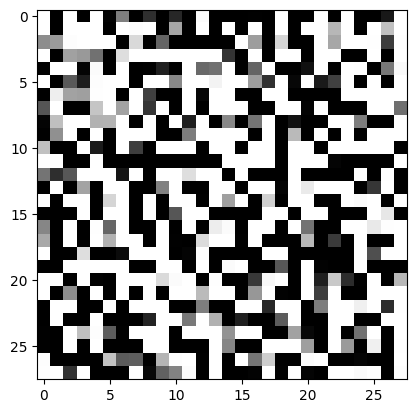

Iteration 2300, Generator Cost: -0.9634129405021667, Discriminator Cost: 1.1989812850952148 Time: 0.3278045654296875
Iteration 2301, Generator Cost: -0.963412880897522, Discriminator Cost: 1.2050073146820068 Time: 0.22031903266906738
Iteration 2302, Generator Cost: -0.9634386301040649, Discriminator Cost: 1.2011675834655762 Time: 0.30452632904052734
Iteration 2303, Generator Cost: -0.9634753465652466, Discriminator Cost: 1.1898614168167114 Time: 0.2118682861328125
Iteration 2304, Generator Cost: -0.9634201526641846, Discriminator Cost: 1.1902958154678345 Time: 0.2190110683441162
Iteration 2305, Generator Cost: -0.963378369808197, Discriminator Cost: 1.2008520364761353 Time: 0.23488426208496094
Iteration 2306, Generator Cost: -0.9633735418319702, Discriminator Cost: 1.1835033893585205 Time: 0.19611334800720215
Iteration 2307, Generator Cost: -0.9633533954620361, Discriminator Cost: 1.207159161567688 Time: 0.1907060146331787
Iteration 2308, Generator Cost: -0.9634414911270142, Discrimina

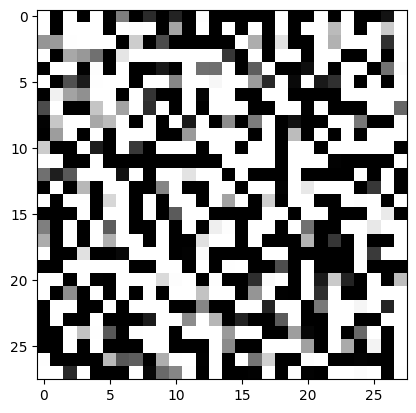

Iteration 2400, Generator Cost: -0.9634355306625366, Discriminator Cost: 1.2003200054168701 Time: 0.33614087104797363
Iteration 2401, Generator Cost: -0.9633610248565674, Discriminator Cost: 1.20687735080719 Time: 0.26618480682373047
Iteration 2402, Generator Cost: -0.9633857607841492, Discriminator Cost: 1.198336124420166 Time: 0.20651841163635254
Iteration 2403, Generator Cost: -0.9633023738861084, Discriminator Cost: 1.201812505722046 Time: 0.19904685020446777
Iteration 2404, Generator Cost: -0.9633546471595764, Discriminator Cost: 1.1964794397354126 Time: 0.20333528518676758
Iteration 2405, Generator Cost: -0.9633162617683411, Discriminator Cost: 1.2109270095825195 Time: 0.19317984580993652
Iteration 2406, Generator Cost: -0.9634454250335693, Discriminator Cost: 1.2066017389297485 Time: 0.19167137145996094
Iteration 2407, Generator Cost: -0.9634562134742737, Discriminator Cost: 1.197229266166687 Time: 0.18970918655395508
Iteration 2408, Generator Cost: -0.963470995426178, Discrimin

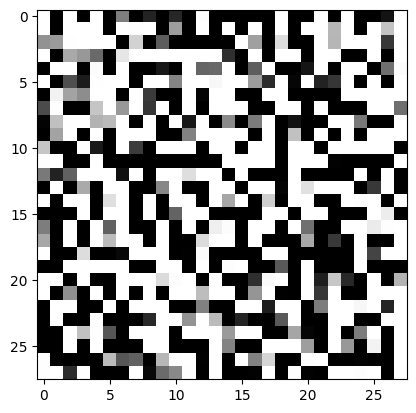

Iteration 2500, Generator Cost: -0.963470458984375, Discriminator Cost: 1.2049832344055176 Time: 0.25005149841308594
Iteration 2501, Generator Cost: -0.9633917808532715, Discriminator Cost: 1.2056384086608887 Time: 0.24250197410583496
Iteration 2502, Generator Cost: -0.9634876251220703, Discriminator Cost: 1.1930742263793945 Time: 0.18230104446411133
Iteration 2503, Generator Cost: -0.9634948968887329, Discriminator Cost: 1.1963809728622437 Time: 0.18263459205627441
Iteration 2504, Generator Cost: -0.9634573459625244, Discriminator Cost: 1.1868845224380493 Time: 0.22085952758789062
Iteration 2505, Generator Cost: -0.9634693264961243, Discriminator Cost: 1.1969468593597412 Time: 0.22686457633972168
Iteration 2506, Generator Cost: -0.9634060859680176, Discriminator Cost: 1.2014747858047485 Time: 0.20264124870300293
Iteration 2507, Generator Cost: -0.9634606838226318, Discriminator Cost: 1.1886074542999268 Time: 0.19646310806274414
Iteration 2508, Generator Cost: -0.9634859561920166, Disc

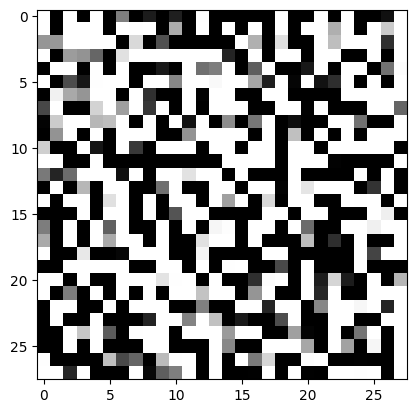

Iteration 2600, Generator Cost: -0.9634276032447815, Discriminator Cost: 1.1781518459320068 Time: 0.3703949451446533
Iteration 2601, Generator Cost: -0.9635156393051147, Discriminator Cost: 1.2098772525787354 Time: 0.22086167335510254
Iteration 2602, Generator Cost: -0.9634739756584167, Discriminator Cost: 1.1917423009872437 Time: 0.17959022521972656
Iteration 2603, Generator Cost: -0.9634830355644226, Discriminator Cost: 1.2000210285186768 Time: 0.1848924160003662
Iteration 2604, Generator Cost: -0.9634152054786682, Discriminator Cost: 1.1924468278884888 Time: 0.27846765518188477
Iteration 2605, Generator Cost: -0.9635289907455444, Discriminator Cost: 1.2116811275482178 Time: 0.2142641544342041
Iteration 2606, Generator Cost: -0.963442862033844, Discriminator Cost: 1.210658073425293 Time: 0.22333312034606934
Iteration 2607, Generator Cost: -0.9634692668914795, Discriminator Cost: 1.1887658834457397 Time: 0.3417172431945801
Iteration 2608, Generator Cost: -0.9634514451026917, Discrimin

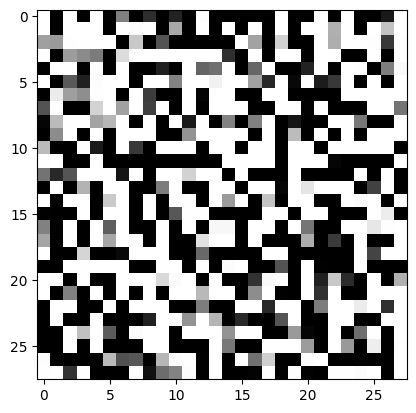

Iteration 2700, Generator Cost: -0.9635515809059143, Discriminator Cost: 1.1955863237380981 Time: 0.35900139808654785
Iteration 2701, Generator Cost: -0.9635634422302246, Discriminator Cost: 1.1975969076156616 Time: 0.22539305686950684
Iteration 2702, Generator Cost: -0.9635527729988098, Discriminator Cost: 1.2076455354690552 Time: 0.19016122817993164
Iteration 2703, Generator Cost: -0.9635797142982483, Discriminator Cost: 1.1964958906173706 Time: 0.168898344039917
Iteration 2704, Generator Cost: -0.9635589122772217, Discriminator Cost: 1.1909353733062744 Time: 0.19962191581726074
Iteration 2705, Generator Cost: -0.9635862708091736, Discriminator Cost: 1.2014111280441284 Time: 0.2223501205444336
Iteration 2706, Generator Cost: -0.9635699391365051, Discriminator Cost: 1.1860603094100952 Time: 0.34735918045043945
Iteration 2707, Generator Cost: -0.9635087847709656, Discriminator Cost: 1.2145676612854004 Time: 0.49360132217407227
Iteration 2708, Generator Cost: -0.9635246992111206, Discri

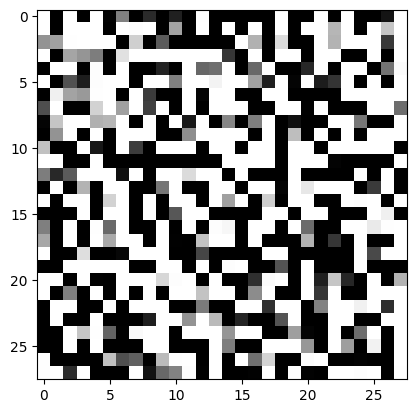

Iteration 2800, Generator Cost: -0.9635812640190125, Discriminator Cost: 1.2026481628417969 Time: 0.31668543815612793
Iteration 2801, Generator Cost: -0.9636020064353943, Discriminator Cost: 1.2085671424865723 Time: 0.2218184471130371
Iteration 2802, Generator Cost: -0.9635217785835266, Discriminator Cost: 1.1970994472503662 Time: 0.23504090309143066
Iteration 2803, Generator Cost: -0.9636148810386658, Discriminator Cost: 1.1954734325408936 Time: 0.2512681484222412
Iteration 2804, Generator Cost: -0.9636319875717163, Discriminator Cost: 1.211628794670105 Time: 0.3291029930114746
Iteration 2805, Generator Cost: -0.9635531902313232, Discriminator Cost: 1.2107620239257812 Time: 0.18159198760986328
Iteration 2806, Generator Cost: -0.9635860323905945, Discriminator Cost: 1.2032115459442139 Time: 0.19959020614624023
Iteration 2807, Generator Cost: -0.9636157155036926, Discriminator Cost: 1.195019006729126 Time: 0.20507264137268066
Iteration 2808, Generator Cost: -0.9635806083679199, Discrimi

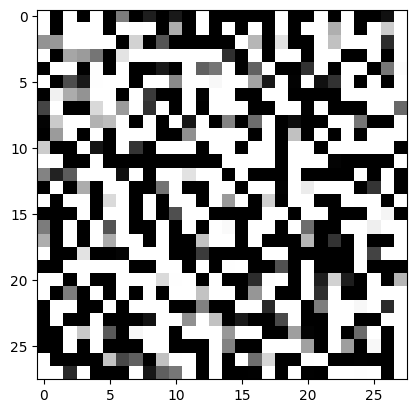

Iteration 2900, Generator Cost: -0.9636104106903076, Discriminator Cost: 1.1892273426055908 Time: 0.386035680770874
Iteration 2901, Generator Cost: -0.9636453986167908, Discriminator Cost: 1.2035332918167114 Time: 0.31371617317199707
Iteration 2902, Generator Cost: -0.9635956287384033, Discriminator Cost: 1.1968262195587158 Time: 0.28793811798095703
Iteration 2903, Generator Cost: -0.963614284992218, Discriminator Cost: 1.2108241319656372 Time: 0.279644250869751
Iteration 2904, Generator Cost: -0.9635509252548218, Discriminator Cost: 1.1993852853775024 Time: 0.37758755683898926
Iteration 2905, Generator Cost: -0.9636353850364685, Discriminator Cost: 1.2012981176376343 Time: 0.46553492546081543
Iteration 2906, Generator Cost: -0.963611900806427, Discriminator Cost: 1.2043858766555786 Time: 0.3080263137817383
Iteration 2907, Generator Cost: -0.9635998606681824, Discriminator Cost: 1.1997798681259155 Time: 0.2892484664916992
Iteration 2908, Generator Cost: -0.9636461138725281, Discriminat

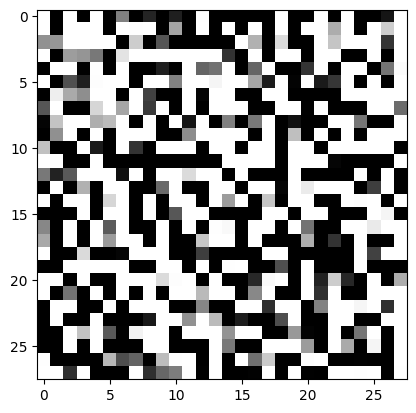

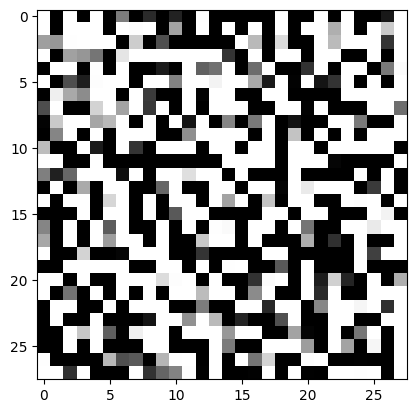

Iteration 3000, Generator Cost: -0.9635598063468933, Discriminator Cost: 1.1997220516204834 Time: 0.3908388614654541
Iteration 3001, Generator Cost: -0.9635857939720154, Discriminator Cost: 1.2009153366088867 Time: 0.2715878486633301
Iteration 3002, Generator Cost: -0.9635574221611023, Discriminator Cost: 1.192224144935608 Time: 0.1865997314453125
Iteration 3003, Generator Cost: -0.9636190533638, Discriminator Cost: 1.20010507106781 Time: 0.4650914669036865
Iteration 3004, Generator Cost: -0.9636422991752625, Discriminator Cost: 1.2140038013458252 Time: 0.26423025131225586
Iteration 3005, Generator Cost: -0.9636897444725037, Discriminator Cost: 1.1924306154251099 Time: 0.2142627239227295
Iteration 3006, Generator Cost: -0.963632345199585, Discriminator Cost: 1.2046098709106445 Time: 0.45215344429016113
Iteration 3007, Generator Cost: -0.9635883569717407, Discriminator Cost: 1.2010306119918823 Time: 0.24106860160827637
Iteration 3008, Generator Cost: -0.9636742472648621, Discriminator C

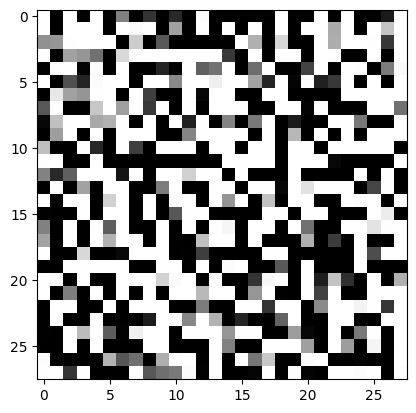

Iteration 3100, Generator Cost: -0.9636804461479187, Discriminator Cost: 1.213570237159729 Time: 1.3562085628509521
Iteration 3101, Generator Cost: -0.9636724591255188, Discriminator Cost: 1.1967241764068604 Time: 0.9914419651031494
Iteration 3102, Generator Cost: -0.9636301398277283, Discriminator Cost: 1.1881663799285889 Time: 0.9607899188995361
Iteration 3103, Generator Cost: -0.9636412262916565, Discriminator Cost: 1.1996670961380005 Time: 1.0313465595245361
Iteration 3104, Generator Cost: -0.9636078476905823, Discriminator Cost: 1.1974341869354248 Time: 0.9288430213928223
Iteration 3105, Generator Cost: -0.9636418223381042, Discriminator Cost: 1.2006771564483643 Time: 0.8755121231079102
Iteration 3106, Generator Cost: -0.9635733962059021, Discriminator Cost: 1.197284460067749 Time: 1.0628931522369385
Iteration 3107, Generator Cost: -0.963672935962677, Discriminator Cost: 1.2056468725204468 Time: 1.017106056213379
Iteration 3108, Generator Cost: -0.9636480212211609, Discriminator C

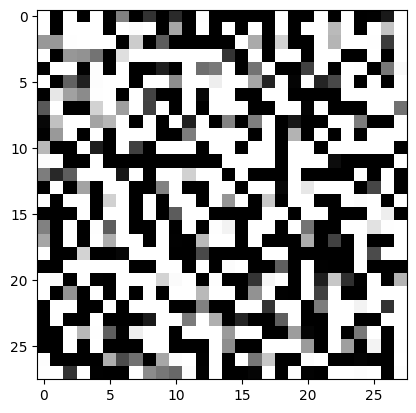

Iteration 3200, Generator Cost: -0.96370530128479, Discriminator Cost: 1.2036463022232056 Time: 0.31627845764160156
Iteration 3201, Generator Cost: -0.9636960029602051, Discriminator Cost: 1.2104949951171875 Time: 0.21474146842956543
Iteration 3202, Generator Cost: -0.9636593461036682, Discriminator Cost: 1.2140740156173706 Time: 0.4025993347167969
Iteration 3203, Generator Cost: -0.9636452198028564, Discriminator Cost: 1.2104241847991943 Time: 0.4222886562347412
Iteration 3204, Generator Cost: -0.9636005163192749, Discriminator Cost: 1.1986339092254639 Time: 0.9060883522033691
Iteration 3205, Generator Cost: -0.9636470079421997, Discriminator Cost: 1.1989684104919434 Time: 0.743384838104248
Iteration 3206, Generator Cost: -0.9637235999107361, Discriminator Cost: 1.2000457048416138 Time: 0.7404508590698242
Iteration 3207, Generator Cost: -0.9636695981025696, Discriminator Cost: 1.2004344463348389 Time: 0.7398905754089355
Iteration 3208, Generator Cost: -0.9635927677154541, Discriminato

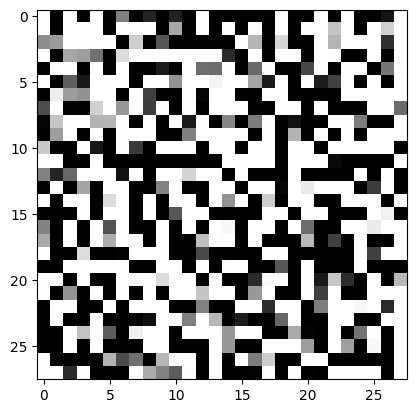

Iteration 3300, Generator Cost: -0.9636861681938171, Discriminator Cost: 1.2035444974899292 Time: 1.3397634029388428
Iteration 3301, Generator Cost: -0.9636642336845398, Discriminator Cost: 1.1943156719207764 Time: 1.2718257904052734
Iteration 3302, Generator Cost: -0.9637341499328613, Discriminator Cost: 1.1991404294967651 Time: 1.1075232028961182
Iteration 3303, Generator Cost: -0.9636471271514893, Discriminator Cost: 1.1928865909576416 Time: 1.007138967514038
Iteration 3304, Generator Cost: -0.9637095928192139, Discriminator Cost: 1.2104475498199463 Time: 1.0449120998382568
Iteration 3305, Generator Cost: -0.9636507630348206, Discriminator Cost: 1.2101547718048096 Time: 0.9111604690551758
Iteration 3306, Generator Cost: -0.9636949896812439, Discriminator Cost: 1.1951310634613037 Time: 1.214510202407837
Iteration 3307, Generator Cost: -0.963714599609375, Discriminator Cost: 1.1976494789123535 Time: 1.307969570159912
Iteration 3308, Generator Cost: -0.9636024236679077, Discriminator C

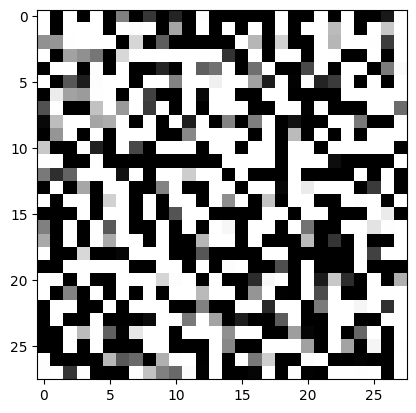

Iteration 3400, Generator Cost: -0.9636754393577576, Discriminator Cost: 1.2120003700256348 Time: 1.2818365097045898
Iteration 3401, Generator Cost: -0.9636821746826172, Discriminator Cost: 1.1979351043701172 Time: 0.9780356884002686
Iteration 3402, Generator Cost: -0.9637499451637268, Discriminator Cost: 1.198793888092041 Time: 1.092569351196289
Iteration 3403, Generator Cost: -0.9637073278427124, Discriminator Cost: 1.209159016609192 Time: 0.9919588565826416
Iteration 3404, Generator Cost: -0.9637159705162048, Discriminator Cost: 1.2111676931381226 Time: 1.0075454711914062
Iteration 3405, Generator Cost: -0.9636943340301514, Discriminator Cost: 1.1933962106704712 Time: 1.1558802127838135
Iteration 3406, Generator Cost: -0.9637098908424377, Discriminator Cost: 1.200819730758667 Time: 1.0035479068756104
Iteration 3407, Generator Cost: -0.9637159109115601, Discriminator Cost: 1.1941865682601929 Time: 0.9448738098144531
Iteration 3408, Generator Cost: -0.963714063167572, Discriminator Co

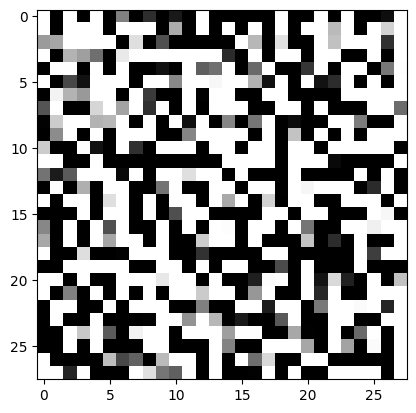

Iteration 3500, Generator Cost: -0.9637385606765747, Discriminator Cost: 1.2019422054290771 Time: 1.3698132038116455
Iteration 3501, Generator Cost: -0.9637646675109863, Discriminator Cost: 1.1972064971923828 Time: 0.8858814239501953
Iteration 3502, Generator Cost: -0.9636528491973877, Discriminator Cost: 1.2095179557800293 Time: 0.9283490180969238
Iteration 3503, Generator Cost: -0.9637159109115601, Discriminator Cost: 1.201177954673767 Time: 0.7200515270233154
Iteration 3504, Generator Cost: -0.9636468291282654, Discriminator Cost: 1.200354814529419 Time: 0.9306156635284424
Iteration 3505, Generator Cost: -0.963777482509613, Discriminator Cost: 1.1910479068756104 Time: 0.8565876483917236
Iteration 3506, Generator Cost: -0.9636761546134949, Discriminator Cost: 1.1999281644821167 Time: 1.1185874938964844
Iteration 3507, Generator Cost: -0.963762104511261, Discriminator Cost: 1.2006090879440308 Time: 0.7631552219390869
Iteration 3508, Generator Cost: -0.9637352228164673, Discriminator C

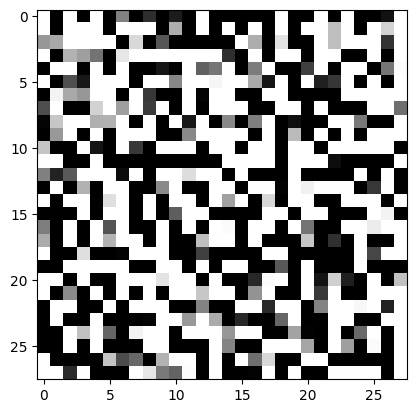

Iteration 3600, Generator Cost: -0.9637435078620911, Discriminator Cost: 1.2103853225708008 Time: 1.401374340057373
Iteration 3601, Generator Cost: -0.963602602481842, Discriminator Cost: 1.2031641006469727 Time: 1.096782922744751
Iteration 3602, Generator Cost: -0.9637255072593689, Discriminator Cost: 1.1912792921066284 Time: 1.338451862335205
Iteration 3603, Generator Cost: -0.9637309908866882, Discriminator Cost: 1.209458827972412 Time: 1.4472072124481201
Iteration 3604, Generator Cost: -0.9636929035186768, Discriminator Cost: 1.2116707563400269 Time: 1.1245737075805664
Iteration 3605, Generator Cost: -0.9637820720672607, Discriminator Cost: 1.1840252876281738 Time: 0.7570455074310303
Iteration 3606, Generator Cost: -0.963737964630127, Discriminator Cost: 1.1867780685424805 Time: 0.8957843780517578
Iteration 3607, Generator Cost: -0.9636573195457458, Discriminator Cost: 1.2114276885986328 Time: 0.8590245246887207
Iteration 3608, Generator Cost: -0.9636446237564087, Discriminator Cos

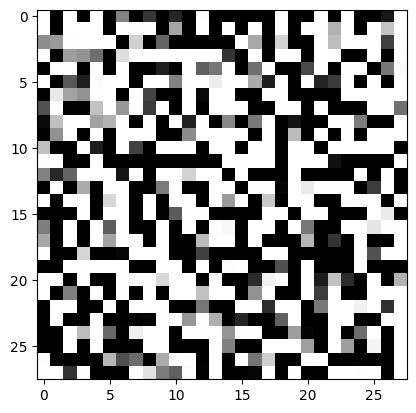

Iteration 3700, Generator Cost: -0.9636945128440857, Discriminator Cost: 1.2218761444091797 Time: 1.365447759628296
Iteration 3701, Generator Cost: -0.9637411236763, Discriminator Cost: 1.2098766565322876 Time: 0.723513126373291
Iteration 3702, Generator Cost: -0.9636169672012329, Discriminator Cost: 1.1961143016815186 Time: 0.9920861721038818
Iteration 3703, Generator Cost: -0.963752269744873, Discriminator Cost: 1.1872131824493408 Time: 0.9526355266571045
Iteration 3704, Generator Cost: -0.9637373089790344, Discriminator Cost: 1.2128987312316895 Time: 1.191535472869873
Iteration 3705, Generator Cost: -0.9637251496315002, Discriminator Cost: 1.2073917388916016 Time: 0.8901019096374512
Iteration 3706, Generator Cost: -0.9636220335960388, Discriminator Cost: 1.206923007965088 Time: 0.9017653465270996
Iteration 3707, Generator Cost: -0.9637814164161682, Discriminator Cost: 1.1962140798568726 Time: 0.9126267433166504
Iteration 3708, Generator Cost: -0.9637271165847778, Discriminator Cost:

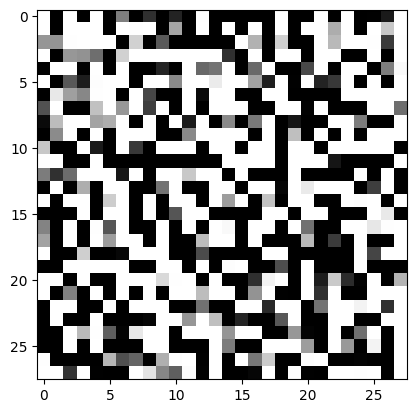

Iteration 3800, Generator Cost: -0.9636385440826416, Discriminator Cost: 1.204986333847046 Time: 1.6874547004699707
Iteration 3801, Generator Cost: -0.9637798070907593, Discriminator Cost: 1.2023329734802246 Time: 1.159292221069336
Iteration 3802, Generator Cost: -0.9637389183044434, Discriminator Cost: 1.2068710327148438 Time: 1.1339714527130127
Iteration 3803, Generator Cost: -0.9637545943260193, Discriminator Cost: 1.1918296813964844 Time: 0.9270286560058594
Iteration 3804, Generator Cost: -0.9637395739555359, Discriminator Cost: 1.1952431201934814 Time: 1.2075610160827637
Iteration 3805, Generator Cost: -0.9636827111244202, Discriminator Cost: 1.2082419395446777 Time: 1.3070580959320068
Iteration 3806, Generator Cost: -0.9637560844421387, Discriminator Cost: 1.2044528722763062 Time: 1.351280927658081
Iteration 3807, Generator Cost: -0.9636993408203125, Discriminator Cost: 1.1961926221847534 Time: 1.345095157623291
Iteration 3808, Generator Cost: -0.9637306332588196, Discriminator C

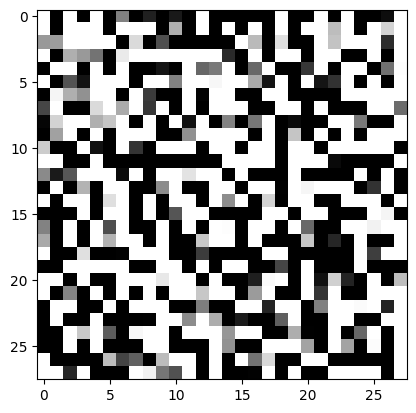

Iteration 3900, Generator Cost: -0.9637594819068909, Discriminator Cost: 1.193845272064209 Time: 1.701157569885254
Iteration 3901, Generator Cost: -0.9636777639389038, Discriminator Cost: 1.199373722076416 Time: 1.3916957378387451
Iteration 3902, Generator Cost: -0.9636862277984619, Discriminator Cost: 1.1982265710830688 Time: 1.774021863937378
Iteration 3903, Generator Cost: -0.9637383222579956, Discriminator Cost: 1.20619535446167 Time: 1.4316353797912598
Iteration 3904, Generator Cost: -0.9637594819068909, Discriminator Cost: 1.195901870727539 Time: 1.660813331604004
Iteration 3905, Generator Cost: -0.9637782573699951, Discriminator Cost: 1.2005670070648193 Time: 1.6757726669311523
Iteration 3906, Generator Cost: -0.9636105895042419, Discriminator Cost: 1.2021349668502808 Time: 1.0976827144622803
Iteration 3907, Generator Cost: -0.9637693762779236, Discriminator Cost: 1.196686029434204 Time: 0.9653778076171875
Iteration 3908, Generator Cost: -0.9637397527694702, Discriminator Cost: 

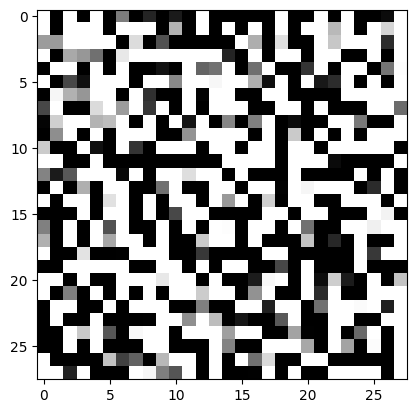

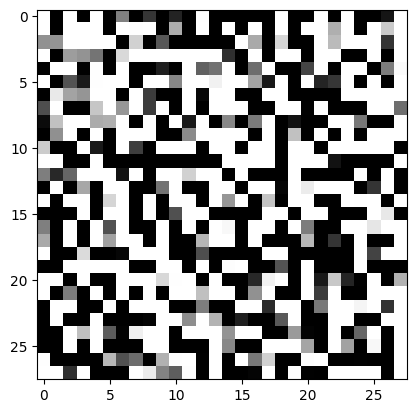

Iteration 4000, Generator Cost: -0.9637040495872498, Discriminator Cost: 1.1979509592056274 Time: 0.83404541015625
Iteration 4001, Generator Cost: -0.9637686014175415, Discriminator Cost: 1.193852424621582 Time: 0.8817856311798096
Iteration 4002, Generator Cost: -0.9637060761451721, Discriminator Cost: 1.202252984046936 Time: 0.6864311695098877
Iteration 4003, Generator Cost: -0.9637282490730286, Discriminator Cost: 1.2031093835830688 Time: 0.8596704006195068
Iteration 4004, Generator Cost: -0.9636152386665344, Discriminator Cost: 1.2096538543701172 Time: 1.0950982570648193
Iteration 4005, Generator Cost: -0.9637601971626282, Discriminator Cost: 1.1826950311660767 Time: 1.000955581665039
Iteration 4006, Generator Cost: -0.9637203812599182, Discriminator Cost: 1.2027831077575684 Time: 1.0104165077209473
Iteration 4007, Generator Cost: -0.963772177696228, Discriminator Cost: 1.1974962949752808 Time: 0.9374265670776367
Iteration 4008, Generator Cost: -0.9636936783790588, Discriminator Cos

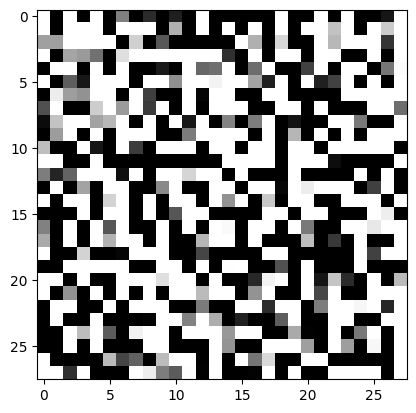

Iteration 4100, Generator Cost: -0.9637773036956787, Discriminator Cost: 1.1918541193008423 Time: 1.140049934387207
Iteration 4101, Generator Cost: -0.9635723829269409, Discriminator Cost: 1.2045906782150269 Time: 1.1563029289245605
Iteration 4102, Generator Cost: -0.963704526424408, Discriminator Cost: 1.2040929794311523 Time: 1.4416706562042236
Iteration 4103, Generator Cost: -0.9637377262115479, Discriminator Cost: 1.204728603363037 Time: 1.668483018875122
Iteration 4104, Generator Cost: -0.9637867212295532, Discriminator Cost: 1.1886460781097412 Time: 1.1489958763122559
Iteration 4105, Generator Cost: -0.9637390971183777, Discriminator Cost: 1.2098398208618164 Time: 1.2951772212982178
Iteration 4106, Generator Cost: -0.9637203812599182, Discriminator Cost: 1.2106024026870728 Time: 1.235499382019043
Iteration 4107, Generator Cost: -0.9635933041572571, Discriminator Cost: 1.1900770664215088 Time: 0.8014605045318604
Iteration 4108, Generator Cost: -0.9636960029602051, Discriminator Co

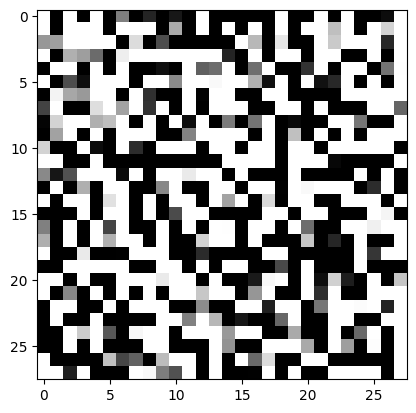

Iteration 4200, Generator Cost: -0.9638208150863647, Discriminator Cost: 1.2015321254730225 Time: 1.2351462841033936
Iteration 4201, Generator Cost: -0.9637476205825806, Discriminator Cost: 1.196150302886963 Time: 1.0615901947021484
Iteration 4202, Generator Cost: -0.9637598395347595, Discriminator Cost: 1.2036168575286865 Time: 1.4972360134124756
Iteration 4203, Generator Cost: -0.9636974930763245, Discriminator Cost: 1.2079033851623535 Time: 1.1547377109527588
Iteration 4204, Generator Cost: -0.9637519717216492, Discriminator Cost: 1.2106828689575195 Time: 1.0494639873504639
Iteration 4205, Generator Cost: -0.9637577533721924, Discriminator Cost: 1.199106216430664 Time: 1.2574207782745361
Iteration 4206, Generator Cost: -0.9636784195899963, Discriminator Cost: 1.1976850032806396 Time: 1.2966375350952148
Iteration 4207, Generator Cost: -0.9638150930404663, Discriminator Cost: 1.1827410459518433 Time: 1.1084067821502686
Iteration 4208, Generator Cost: -0.9638044238090515, Discriminator

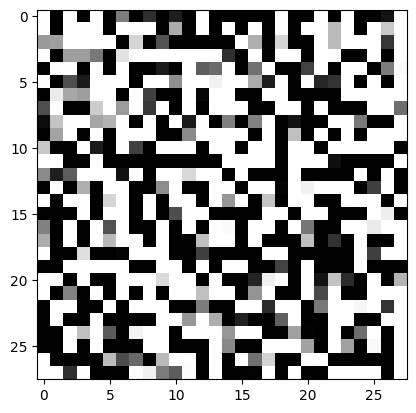

Iteration 4300, Generator Cost: -0.9637202620506287, Discriminator Cost: 1.2019237279891968 Time: 1.0620331764221191
Iteration 4301, Generator Cost: -0.9638029336929321, Discriminator Cost: 1.190153956413269 Time: 1.0413329601287842
Iteration 4302, Generator Cost: -0.9637981653213501, Discriminator Cost: 1.1987290382385254 Time: 0.811704158782959
Iteration 4303, Generator Cost: -0.9637715816497803, Discriminator Cost: 1.204721450805664 Time: 1.069169282913208
Iteration 4304, Generator Cost: -0.9636442065238953, Discriminator Cost: 1.2058966159820557 Time: 0.8694436550140381
Iteration 4305, Generator Cost: -0.9637715816497803, Discriminator Cost: 1.2176628112792969 Time: 0.7949488162994385
Iteration 4306, Generator Cost: -0.9637778401374817, Discriminator Cost: 1.18790864944458 Time: 0.8881826400756836
Iteration 4307, Generator Cost: -0.9637941718101501, Discriminator Cost: 1.208790898323059 Time: 0.9614298343658447
Iteration 4308, Generator Cost: -0.9637097120285034, Discriminator Cost

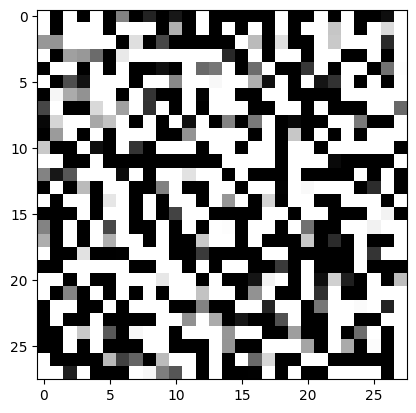

Iteration 4400, Generator Cost: -0.963763415813446, Discriminator Cost: 1.196365237236023 Time: 0.9790675640106201
Iteration 4401, Generator Cost: -0.9637882709503174, Discriminator Cost: 1.2228267192840576 Time: 0.9708468914031982
Iteration 4402, Generator Cost: -0.9636713266372681, Discriminator Cost: 1.210981845855713 Time: 1.1342833042144775
Iteration 4403, Generator Cost: -0.9637551307678223, Discriminator Cost: 1.1924015283584595 Time: 0.959909200668335
Iteration 4404, Generator Cost: -0.9637457132339478, Discriminator Cost: 1.1969882249832153 Time: 0.9997758865356445
Iteration 4405, Generator Cost: -0.9636741876602173, Discriminator Cost: 1.199318528175354 Time: 1.0333242416381836
Iteration 4406, Generator Cost: -0.9637678265571594, Discriminator Cost: 1.1937146186828613 Time: 0.7748091220855713
Iteration 4407, Generator Cost: -0.9637241959571838, Discriminator Cost: 1.2178361415863037 Time: 1.0170068740844727
Iteration 4408, Generator Cost: -0.9636847972869873, Discriminator Co

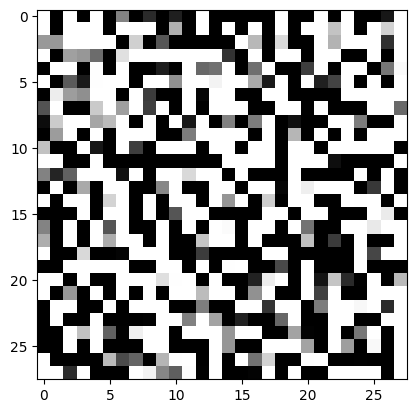

Iteration 4500, Generator Cost: -0.9637450575828552, Discriminator Cost: 1.207057237625122 Time: 0.7154278755187988
Iteration 4501, Generator Cost: -0.9636447429656982, Discriminator Cost: 1.1969386339187622 Time: 0.7286763191223145
Iteration 4502, Generator Cost: -0.9636875987052917, Discriminator Cost: 1.1982566118240356 Time: 0.8268678188323975
Iteration 4503, Generator Cost: -0.9636940956115723, Discriminator Cost: 1.19698166847229 Time: 0.9655795097351074
Iteration 4504, Generator Cost: -0.9638234972953796, Discriminator Cost: 1.206946611404419 Time: 0.8200912475585938
Iteration 4505, Generator Cost: -0.9637482166290283, Discriminator Cost: 1.2031134366989136 Time: 0.9428365230560303
Iteration 4506, Generator Cost: -0.9637876749038696, Discriminator Cost: 1.2096521854400635 Time: 1.020580530166626
Iteration 4507, Generator Cost: -0.9637157917022705, Discriminator Cost: 1.194854974746704 Time: 1.1503677368164062
Iteration 4508, Generator Cost: -0.9638025164604187, Discriminator Cos

In [ ]:
generator = Decoder().to(device)
discriminator = Encoder().to(device)
train(mode = 'wgan'
      , train_loader=train_loader
      , gen_iters = GEN_ITERS
      , critic_iters=CRITIC_ITERS
      ,batch_size = BATCH_SIZE
      ,discriminator = discriminator
      ,generator = generator
      ,val_loader=test_loader)

In [ ]:
""
# Define the transform to convert the images to tensors and normalize them and resize them to 32X32 to match CIFAR input

transform = transforms.Compose([
    transforms.ToTensor(),
])
# Download and load the training data
train_dataset = datasets.FashionMNIST(root=_PATH, train=True, download=True, transform=transform)
test_dataset = datasets.FashionMNIST(root=_PATH, train=False, download=True, transform=transform)

# Create DataLoader for training and testing
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

train_iter = iter(train_loader)
